In [15]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

In [16]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [17]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

221473


In [18]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [19]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [20]:
def nlp_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding_layer = embedding_layer(inputs)

    lstm1 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(embedding_layer)
    lstm2 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(lstm1)
    output = Dense(units=1, activation='sigmoid')(lstm2[1])
    
    model = Model(inputs, output)
    return model


model = nlp_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.00005)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 255)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 255, 100)     22147300    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) [(None, 255, 200), ( 160800      embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) [(None, 255, 200), ( 240800      bidirectional_4[0][0]            
                                                                 bidirectional_4[0][1] 

Epoch 18/100
133/133 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9577
Epoch 00018: val_accuracy did not improve from 0.88669
133/133 [==============================] - 5s 38ms/step - loss: 0.1257 - accuracy: 0.9577 - val_loss: 0.3106 - val_accuracy: 0.8820
Epoch 19/100
133/133 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9589
Epoch 00019: val_accuracy did not improve from 0.88669
133/133 [==============================] - 5s 38ms/step - loss: 0.1172 - accuracy: 0.9589 - val_loss: 0.3204 - val_accuracy: 0.8801
Epoch 20/100
133/133 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9660
Epoch 00020: val_accuracy did not improve from 0.88669
133/133 [==============================] - 5s 37ms/step - loss: 0.1089 - accuracy: 0.9660 - val_loss: 0.3317 - val_accuracy: 0.8839
Epoch 21/100
133/133 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9695
Epoch 00021: val_accuracy did not improve from 

Epoch 47/100
133/133 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9976
Epoch 00047: val_accuracy improved from 0.88669 to 0.88763, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 40ms/step - loss: 0.0130 - accuracy: 0.9976 - val_loss: 0.5140 - val_accuracy: 0.8876
Epoch 48/100
133/133 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9967
Epoch 00048: val_accuracy did not improve from 0.88763
133/133 [==============================] - 5s 37ms/step - loss: 0.0152 - accuracy: 0.9967 - val_loss: 0.5521 - val_accuracy: 0.8791
Epoch 49/100
133/133 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9766
Epoch 00049: val_accuracy did not improve from 0.88763
133/133 [==============================] - 5s 37ms/step - loss: 0.0642 - accuracy: 0.9766 - val_loss: 0.4570 - val_accuracy: 0.8801
Epoch 50/100
133/133 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.99

Epoch 76/100
133/133 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9981
Epoch 00076: val_accuracy did not improve from 0.88857
133/133 [==============================] - 5s 37ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.6269 - val_accuracy: 0.8820
Epoch 77/100
133/133 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9934
Epoch 00077: val_accuracy did not improve from 0.88857
133/133 [==============================] - 5s 37ms/step - loss: 0.0231 - accuracy: 0.9934 - val_loss: 0.5724 - val_accuracy: 0.8857
Epoch 78/100
133/133 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9995
Epoch 00078: val_accuracy did not improve from 0.88857
133/133 [==============================] - 5s 37ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.5865 - val_accuracy: 0.8886
Epoch 79/100
133/133 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9995
Epoch 00079: val_accuracy did not improve from 

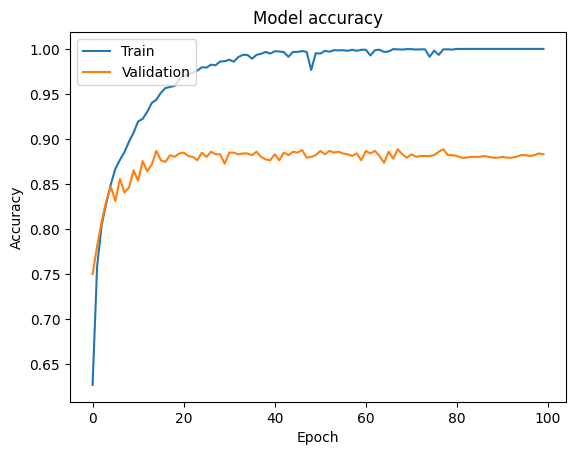

In [21]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model = load_model('./weight_cp/weight_lstm.hdf5')
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       661
           1       0.88      0.90      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8873771730914588


In [23]:
def nlp_ds(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding_layer = embedding_layer(inputs)

    lstm1 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(embedding_layer)
    lstm2 = Bidirectional(LSTM(100,return_sequences=True, return_state=True))(lstm1)
    
    output1 = Dense(units=1, activation='sigmoid', name='lstm_1')(lstm1[1])
    output2 = Dense(units=1, activation='sigmoid', name='lstm_2')(lstm2[1])
    model = Model(inputs, [output1, output2])
    return model


model = nlp_ds(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm.hdf5', save_freq="epoch",  verbose=1, monitor='val_lstm_2_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.00005)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 255)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 255, 100)     22147300    input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) [(None, 255, 200), ( 160800      embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) [(None, 255, 200), ( 240800      bidirectional_6[0][0]            
                                                                 bidirectional_6[0][1] 

Epoch 10/100
133/133 [==============================] - ETA: 0s - loss: 0.6254 - lstm_1_loss: 0.3742 - lstm_2_loss: 0.2512 - lstm_1_accuracy: 0.8455 - lstm_2_accuracy: 0.8979
Epoch 00010: val_lstm_2_accuracy did not improve from 0.86497
133/133 [==============================] - 5s 37ms/step - loss: 0.6254 - lstm_1_loss: 0.3742 - lstm_2_loss: 0.2512 - lstm_1_accuracy: 0.8455 - lstm_2_accuracy: 0.8979 - val_loss: 0.7270 - val_lstm_1_loss: 0.3968 - val_lstm_2_loss: 0.3302 - val_lstm_1_accuracy: 0.8329 - val_lstm_2_accuracy: 0.8508
Epoch 11/100
133/133 [==============================] - ETA: 0s - loss: 0.5985 - lstm_1_loss: 0.3554 - lstm_2_loss: 0.2431 - lstm_1_accuracy: 0.8566 - lstm_2_accuracy: 0.8991
Epoch 00011: val_lstm_2_accuracy improved from 0.86497 to 0.86780, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 41ms/step - loss: 0.5985 - lstm_1_loss: 0.3554 - lstm_2_loss: 0.2431 - lstm_1_accuracy: 0.8566 - lstm_2_accuracy: 0.8991 - val_loss:

Epoch 25/100
133/133 [==============================] - ETA: 0s - loss: 0.3110 - lstm_1_loss: 0.2170 - lstm_2_loss: 0.0940 - lstm_1_accuracy: 0.9147 - lstm_2_accuracy: 0.9702
Epoch 00025: val_lstm_2_accuracy improved from 0.88574 to 0.88857, saving model to ./weight_cp\weight_lstm.hdf5
133/133 [==============================] - 5s 39ms/step - loss: 0.3110 - lstm_1_loss: 0.2170 - lstm_2_loss: 0.0940 - lstm_1_accuracy: 0.9147 - lstm_2_accuracy: 0.9702 - val_loss: 0.6281 - val_lstm_1_loss: 0.3009 - val_lstm_2_loss: 0.3272 - val_lstm_1_accuracy: 0.8744 - val_lstm_2_accuracy: 0.8886
Epoch 26/100
133/133 [==============================] - ETA: 0s - loss: 0.2921 - lstm_1_loss: 0.2074 - lstm_2_loss: 0.0847 - lstm_1_accuracy: 0.9241 - lstm_2_accuracy: 0.9738
Epoch 00026: val_lstm_2_accuracy did not improve from 0.88857
133/133 [==============================] - 5s 36ms/step - loss: 0.2921 - lstm_1_loss: 0.2074 - lstm_2_loss: 0.0847 - lstm_1_accuracy: 0.9241 - lstm_2_accuracy: 0.9738 - val_loss:

133/133 [==============================] - ETA: 0s - loss: 0.1737 - lstm_1_loss: 0.1448 - lstm_2_loss: 0.0289 - lstm_1_accuracy: 0.9534 - lstm_2_accuracy: 0.9943
Epoch 00040: val_lstm_2_accuracy did not improve from 0.89424
133/133 [==============================] - 5s 36ms/step - loss: 0.1737 - lstm_1_loss: 0.1448 - lstm_2_loss: 0.0289 - lstm_1_accuracy: 0.9534 - lstm_2_accuracy: 0.9943 - val_loss: 0.7266 - val_lstm_1_loss: 0.2989 - val_lstm_2_loss: 0.4277 - val_lstm_1_accuracy: 0.8782 - val_lstm_2_accuracy: 0.8924
Epoch 41/100
133/133 [==============================] - ETA: 0s - loss: 0.1693 - lstm_1_loss: 0.1413 - lstm_2_loss: 0.0280 - lstm_1_accuracy: 0.9553 - lstm_2_accuracy: 0.9939
Epoch 00041: val_lstm_2_accuracy did not improve from 0.89424
133/133 [==============================] - 5s 36ms/step - loss: 0.1693 - lstm_1_loss: 0.1413 - lstm_2_loss: 0.0280 - lstm_1_accuracy: 0.9553 - lstm_2_accuracy: 0.9939 - val_loss: 0.7541 - val_lstm_1_loss: 0.2993 - val_lstm_2_loss: 0.4547 - v

133/133 [==============================] - ETA: 0s - loss: 0.1049 - lstm_1_loss: 0.0922 - lstm_2_loss: 0.0127 - lstm_1_accuracy: 0.9754 - lstm_2_accuracy: 0.9979
Epoch 00055: val_lstm_2_accuracy did not improve from 0.89707
133/133 [==============================] - 5s 36ms/step - loss: 0.1049 - lstm_1_loss: 0.0922 - lstm_2_loss: 0.0127 - lstm_1_accuracy: 0.9754 - lstm_2_accuracy: 0.9979 - val_loss: 0.8070 - val_lstm_1_loss: 0.3154 - val_lstm_2_loss: 0.4916 - val_lstm_1_accuracy: 0.8848 - val_lstm_2_accuracy: 0.8895
Epoch 56/100
133/133 [==============================] - ETA: 0s - loss: 0.1019 - lstm_1_loss: 0.0902 - lstm_2_loss: 0.0117 - lstm_1_accuracy: 0.9764 - lstm_2_accuracy: 0.9983
Epoch 00056: val_lstm_2_accuracy did not improve from 0.89707
133/133 [==============================] - 5s 36ms/step - loss: 0.1019 - lstm_1_loss: 0.0902 - lstm_2_loss: 0.0117 - lstm_1_accuracy: 0.9764 - lstm_2_accuracy: 0.9983 - val_loss: 0.8038 - val_lstm_1_loss: 0.3173 - val_lstm_2_loss: 0.4865 - v

133/133 [==============================] - ETA: 0s - loss: 0.0748 - lstm_1_loss: 0.0642 - lstm_2_loss: 0.0106 - lstm_1_accuracy: 0.9837 - lstm_2_accuracy: 0.9981
Epoch 00070: val_lstm_2_accuracy did not improve from 0.89802
133/133 [==============================] - 5s 36ms/step - loss: 0.0748 - lstm_1_loss: 0.0642 - lstm_2_loss: 0.0106 - lstm_1_accuracy: 0.9837 - lstm_2_accuracy: 0.9981 - val_loss: 0.8685 - val_lstm_1_loss: 0.3570 - val_lstm_2_loss: 0.5115 - val_lstm_1_accuracy: 0.8744 - val_lstm_2_accuracy: 0.8801
Epoch 71/100
133/133 [==============================] - ETA: 0s - loss: 0.0704 - lstm_1_loss: 0.0618 - lstm_2_loss: 0.0087 - lstm_1_accuracy: 0.9851 - lstm_2_accuracy: 0.9986
Epoch 00071: val_lstm_2_accuracy did not improve from 0.89802
133/133 [==============================] - 5s 36ms/step - loss: 0.0704 - lstm_1_loss: 0.0618 - lstm_2_loss: 0.0087 - lstm_1_accuracy: 0.9851 - lstm_2_accuracy: 0.9986 - val_loss: 0.8808 - val_lstm_1_loss: 0.3599 - val_lstm_2_loss: 0.5209 - v

Epoch 86/100
133/133 [==============================] - ETA: 0s - loss: 0.0543 - lstm_1_loss: 0.0439 - lstm_2_loss: 0.0104 - lstm_1_accuracy: 0.9905 - lstm_2_accuracy: 0.9976
Epoch 00086: val_lstm_2_accuracy did not improve from 0.89802
133/133 [==============================] - 5s 36ms/step - loss: 0.0543 - lstm_1_loss: 0.0439 - lstm_2_loss: 0.0104 - lstm_1_accuracy: 0.9905 - lstm_2_accuracy: 0.9976 - val_loss: 0.9302 - val_lstm_1_loss: 0.3946 - val_lstm_2_loss: 0.5355 - val_lstm_1_accuracy: 0.8810 - val_lstm_2_accuracy: 0.8867
Epoch 87/100
133/133 [==============================] - ETA: 0s - loss: 0.0513 - lstm_1_loss: 0.0417 - lstm_2_loss: 0.0096 - lstm_1_accuracy: 0.9917 - lstm_2_accuracy: 0.9976
Epoch 00087: val_lstm_2_accuracy did not improve from 0.89802
133/133 [==============================] - 5s 36ms/step - loss: 0.0513 - lstm_1_loss: 0.0417 - lstm_2_loss: 0.0096 - lstm_1_accuracy: 0.9917 - lstm_2_accuracy: 0.9976 - val_loss: 0.9191 - val_lstm_1_loss: 0.4031 - val_lstm_2_los

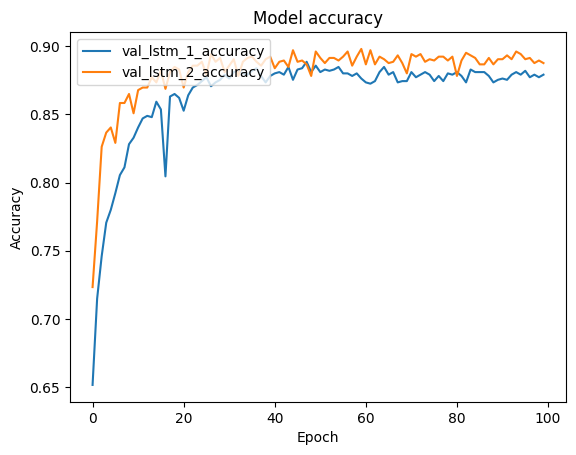

In [24]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_lstm_1_accuracy'])
plt.plot(history.history['val_lstm_2_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_lstm_1_accuracy', 'val_lstm_2_accuracy'], loc='upper left')
plt.show()

In [30]:
model = load_model('./weight_cp/weight_lstm.hdf5')
predictions1 = model.predict(X_test)[0]
predictions2 = model.predict(X_test)[1]
print(predictions1.shape)
predictions = np.mean((predictions1, predictions2), axis=0)
print(predictions.shape)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM DS (Averaged)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

(1323, 1)
(1323, 1)
CLASSIFICATION REPORT OF LSTM DS (Averaged)
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       661
           1       0.89      0.89      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8934240362811792


In [31]:
predictions = np.where(predictions2 > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM DS (Last Layer)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM DS (Last Layer)
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       661
           1       0.88      0.90      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8858654572940288


In [32]:
predictions = np.where(predictions1 > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM DS (First Layer)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM DS (First Layer)
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       661
           1       0.90      0.86      0.88       662

    accuracy                           0.88      1323
   macro avg       0.88      0.88      0.88      1323
weighted avg       0.88      0.88      0.88      1323

0.8820861678004536
